# MIDOG++ Demo: Investigating Class Separability in Object Detection Models
Welcome to the **MIDOG++ Demo Notebook!** This notebook is designed to demonstrate the use of the **Hellinger Distance Value (HDV)** for evaluating class separability in object detection models, specifically using the **YOLOv7-D6** architecture on the **MIDOG++ dataset**.

## What you will learn in this demo
In this notebook, we will guide you through the following steps:

1. Setup the environment to run this notebook.

2. Download and prepare the MIDOG++ dataset.

3. Training a YOLOv7-D6 Model. Learn how to train a YOLOv7-D6 model on the HBC cases of the MIDOG++ dataset. *(Pre-trained weights are also provided if you prefer to skip the training process.)*

4. Evaluate your model on the MIDOGpp test cases to get performance metrics.

3. Extract features from the trained YOLOv7-D6 model to analyze its latent space.

6. Computing the HDV metric and visualizing the results to gain insights into the model's discriminative power and its behavior across different layers and coordinates.

## 1. Setup the environment
Follow the instructions in the `README` under the `Getting started` section before running this notebok. Then switch to the new kernel in the notebook. Go to the top menu and select: 
- `Kernel > Change Kernel > demo_env`

Verify the environment:


In [ ]:
import sys
print(f"Current Python executable: {sys.executable}")
!pip list

## 2. Download the MIDOG++ dataset
First we need to download the data. The total size of the dataset is 65 GB so running the script can take a while. The recommended location for the downloaded files is at `images`. If you want to specify your own location you will have to adapt it later on in this notebook. 

In [ ]:
# Download MIDOG++ to images/
!python download_midogpp.py --location images

Next, we want to prepare the MIDOG++ dataset for training, validation and testing. For this demo, we will train and evaluate only on the HBC cases. Testing and feature extraction will be performed on all other cases. We will take the provided json file and split the HBC cases randomly to train, val and test using a 60/20/20 split. All non-HBC cases go to the test set by default. 

In [71]:
import json
import pandas as pd

def create_demo_datasets(json_file):
    """Converts the MIDOG++ json file to pandas dataframe with human breast cancer samples in all splits."""
    database = json.load(open(json_file, 'rb'))

    # Read image data
    image_df = pd.DataFrame.from_dict(database['images'])
    image_df = image_df.drop(columns=['license', 'width', 'height'])
    image_df = image_df.rename({'id':'image_id', 'tumor_type':'tumortype', 'file_name':'filename'}, axis=1)

    # Create train, val, test splits including HBC in test set
    random_seed = 42
    hbc_df = image_df.query('tumortype == "human breast cancer"')

    # Split HBC data: 60% train, 20% valid, 20% test
    train_ids = hbc_df.sample(frac=0.6, random_state=random_seed)['image_id']
    remaining_hbc = hbc_df[~hbc_df['image_id'].isin(train_ids)]
    valid_ids = remaining_hbc.sample(frac=0.5, random_state=random_seed)['image_id']
    test_hbc_ids = remaining_hbc[~remaining_hbc['image_id'].isin(valid_ids)]['image_id']

    # Assign splits
    image_df['split'] = 'test'  # All non-HBC samples go to test by default
    image_df.loc[image_df['image_id'].isin(train_ids), 'split'] = 'train'
    image_df.loc[image_df['image_id'].isin(valid_ids), 'split'] = 'val'
    image_df.loc[image_df['image_id'].isin(test_hbc_ids), 'split'] = 'test'

    # Read annotations
    annotations_df = pd.DataFrame.from_dict(database['annotations'])
    annotations_df = annotations_df.assign(x=annotations_df['bbox'].apply(lambda x: int((x[0] + x[2]) / 2)))
    annotations_df = annotations_df.assign(y=annotations_df['bbox'].apply(lambda x: int((x[1] + x[3]) / 2)))
    annotations_df = annotations_df.drop(columns=['bbox', 'labels', 'id'])

    # Merge data, rename and rearrange
    comb_df = image_df.merge(annotations_df, how='right', on='image_id')
    comb_df = comb_df.rename({'category_id': 'label', 'image_id': 'slide'}, axis=1)
    comb_df = comb_df[['x', 'y', 'label', 'filename', 'slide', 'split', 'tumortype']]

    return comb_df

In [72]:
from pathlib import Path 

# Set the path to the downloaded images 
img_dir = Path('images')
json_file = img_dir / 'MIDOGpp.json'

# Create the demo dataset 
demo_ds = create_demo_datasets(json_file)

# Save the demo dataset
demo_ds.to_csv(img_dir.joinpath('MIDOGpp_demo.csv'))

Lets have a brief look at the dataset! 

In [5]:
# The number of files per train, val, test split
print(demo_ds.groupby('split')['filename'].nunique())

split
test     379
train     93
val       31
Name: filename, dtype: int64


So in our demo dataset, there are 93 HBC cases in the training set, 31 HBC cases in the validation set, and all other 379 cases are in the test set. 

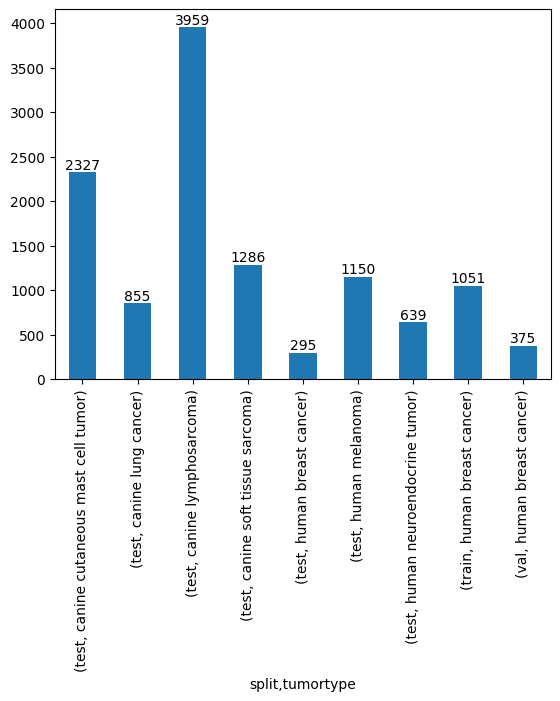

In [6]:
import matplotlib.pyplot as plt

ax = demo_ds.query('label == 1').groupby(['split', 'tumortype']).size().plot(kind='bar')
ax.bar_label(ax.containers[0])
plt.show()

Looking at the distribution of mitotic figures (MFs) across the tumortypes and datasets, we can see that we have 1000 MFs for training and about 375 for evaluation on the HBC cases. Looking at the test set, we have 295 remaining MFs of the HBC cases. The most MFs with 3959 samples are come from the canine lymphosarcoma (CLYM). Second most MFs come from the canine cutaneous mast cell tumor (CCMCT) with 2327 samples. The least amount of MFs from an unseen domain are found in the human neuroendocrine tumor (HNET) cases with 639 cases. The canine soft tissue sarcoma cases (CSTS) are new cases that were not part of previous MIDOG datasets. The human melanoma cases (HMEL) were part of the MIDOG 2022 challenge, however they were provided unlabelled during the challenge. 

Let's look at some examples from the different domains. 

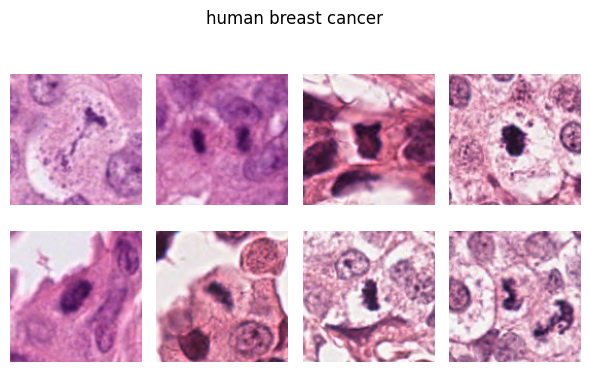

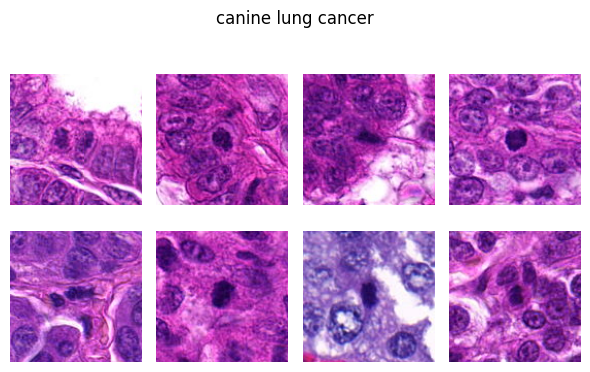

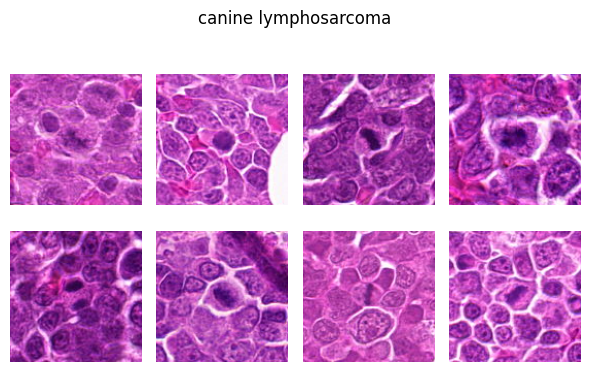

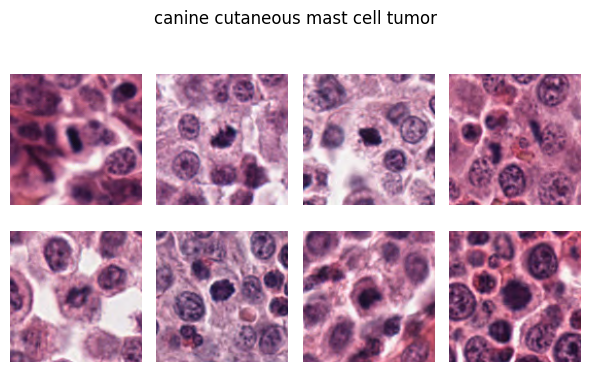

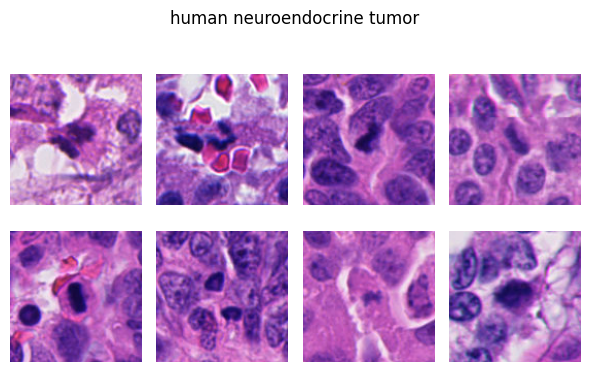

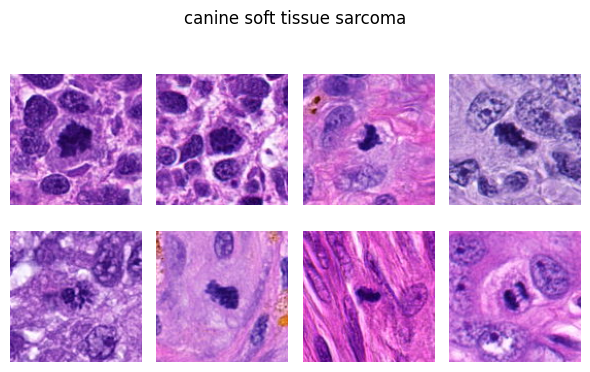

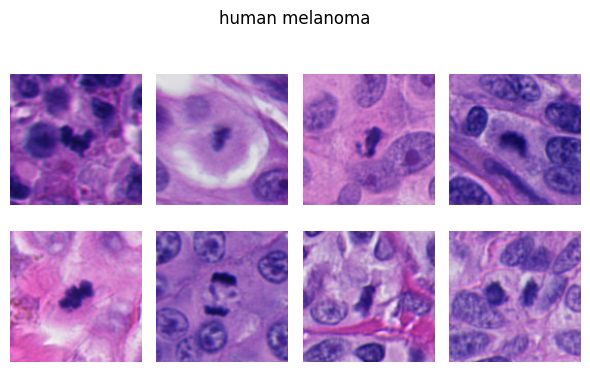

In [7]:
from PIL import Image 
from pathlib import Path 

img_dir = Path('images')
tumor_types = demo_ds.tumortype.unique().tolist()
size = 128

for tumor_type in tumor_types:
    tumor_samples = demo_ds.query('label == 1 & tumortype == @tumor_type').sample(n=8)
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(6,4))
    for idx, ax in enumerate(axs.flatten()):
        x, y, filename = tumor_samples.iloc[idx][['x', 'y', 'filename']]
        img = Image.open(img_dir / filename)
        patch = img.crop([x-size/2, y-size/2, x+size/2, y+size/2])
        ax.imshow(patch)
        ax.axis('off')
    plt.suptitle(tumor_type)
    plt.tight_layout()
    plt.show()


## 3. Train your own YOLOv7-D6
We adapted the official YOLOv7 implementation to deal with our online sampling approach. You can either decide to train your own YOLOv7 model, or you can skip this step and use the weights that we provided.

### Train your own YOLOv7 model

If you want to train your own model, you can use the commands the below. This will train a YOLOv7-D6 using a batch size of 6 with a patch size of 1280x1280 for 100 epochs and 512 samples per epoch which needs about 23.1 GB of GPU memory. The model will be saved to `runs/train/yolov7d6_demo`. You may need to login to to your wandb account. Make sure that the `yolov7-d6_training.pt` checkpoint is downloaded and in the main directory of this repository. ***If you want to skip this step head over to the next section (4.).***

In [ ]:
!python3 train_aux.py --cfg cfg/training/yolov7-d6-midog.yaml --name yolov7d6_demo --data data/midog.yaml --img_dir images/ --dataset images/MIDOGpp_demo.csv --batch-size 6 --img-size 1280 1280 --weights yolov7-d6_training.pt --adam --hyp data/hyp.scratch.custom.yaml --gradient_clip_norm 5 --sampling_strategy default --epochs 100 --noautoanchor --num_samples 512

If you trained your own model, we want to optimize its detection threshold for optimal performance. The following script will test the detection performance for a range of detection thresholds on the validation set and save the detection threshold with the best F1 score to the model configurations. The saved model configurations will be stored at `demo_models/yolov7d6_demo.yaml`. 

In [ ]:
!python3 optimize_threshold.py --batch_size 6 --cfg cfg/training/yolov7-d6-midog.yaml --dataset_file images/midogpp_demo.csv --detector yolov7_d6 --img_dir images/ --model_name yolov7d6_demo --weights runs/train/yolov7d6_demo/weights/best.pt --config_path demo_models

## 4. Evaluate a YOLOv7-D6 on the MIDOGpp dataset

We can use the optimized models to evaluate the performance on the unseen test domains of our dataset. You can either use your own model that you just trained in the previous steps or use our provided model from `demo_models/yolov7d6_demo.yaml`. The output file will be created based on the model name and saved to `demo_results/yolov7d6_demo.json`.

In [ ]:
# select the config_file that you would like to evaluate
!python3 evaluate.py --config_file demo_models/yolov7d6_demo.yaml --dataset_file images/MIDOGpp_demo.csv --img_dir images/ --save_path demo_results 

If you did not select a specific output file. We can view the results with the following:

In [93]:
import json
from typing import Dict

def load_metrics(
        filename: str,
        metric: str
        ) -> Dict[str, float]:
    """
    Load specific metrics from result file.

    Args:
        filename (str): Path to the JSON file containing metrics.
        metric (str): The metric suffix to filter (e.g., '_accuracy').

    Returns:
        Dict[str, float]: Dictionary mapping tumor types to their metric values.

    Raises:
        FileNotFoundError: If the specified file doesn't exist.
        json.JSONDecodeError: If the file contains invalid JSON.
    """
    try:
        with open(filename, 'r') as f:
            all_metric_data = json.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"Metrics file not found: {filename}")
    except json.JSONDecodeError:
        raise json.JSONDecodeError(f"Invalid JSON format in file: {filename}")

    aggregates = all_metric_data['aggregates']
    aggregates = {
        key.split('_')[1]: value for key, value in aggregates.items()
        if key.startswith('tumor') and key.endswith(metric)
    }
    codes = {idx: tumor for idx, tumor in enumerate(aggregates.keys())}
    inverted_codes = {tumor: idx for idx, tumor in codes.items()}
    aggregates = {inverted_codes[t]: v for t, v in aggregates.items()}
    return aggregates, codes 

In [94]:
import json
from pprint import pprint

# Enter result file 
result_file = 'results/yolov7_d6_demo.json'

# Open result file
f1_scores, codes = load_metrics(result_file, metric='f1')

# Show f1 results 
pprint({codes[k]: v for k, v in f1_scores.items()})

{'caninecutaneousmastcelltumor': 0.7258382643673968,
 'caninelungcancer': 0.23880597090666073,
 'caninelymphosarcoma': 0.18960802206253233,
 'caninesofttissuesarcoma': 0.5723014258796836,
 'humanbreastcancer': 0.7131782951294994,
 'humanmelanoma': 0.7201125177120898,
 'humanneuroendocrinetumor': 0.5074626869540748}


For our demo model, we can see that the model performs best on the CCMCT, HBC, and HMEL cases with F1-Scores greater than 0.7. Our demo model performs worst on the CLYM cases with an F1-Score of 0.1896.

## 5. Extract features from the test cases

In order to calculate the HDV metric we need to extract the features from our objects in the test domains. You can either extract the features for your own model or use our demo model. Extracting the features may take a while. The results will be saved to `demo_results/`. 

In [ ]:
# If you want to extract features of your own model specifiy the config file
!python3 extract_features.py --config_file demo_models/yolov7d6_demo.yaml --save_path demo_results --batch_size 16 --dataset_file images/MIDOGpp_demo.csv --img_dir images/

## 6. Calculate the HDV 

Now we want to calculate the HDV for each unseen domain in our test set. We first calculate the metric with the following script. Then we will load and visualize the results. **We can compute the metric only if you extracted the features from the previous step.** 

In [ ]:
# Specify the config file if you want to use your own model 
# Results will be saved to demo_results/hdv_model_name.pkl
!python3 compute_distance.py --config_file demo_models/yolov7d6_demo.yaml --dataset_file images/midogpp_demo.csv --img_dir images/ --save_dir demo_results/ --feature_dir demo_results/

If you completed the previous step and calculated the metric. We can now visulize the results. 

In [43]:
# Some functions to load and visualize results 

import itertools
import json
import os
from typing import Dict, Optional, Union, List, Tuple
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objects as go
import utils.constants as constants
from plotly.subplots import make_subplots


def load_metrics(
        filename: str,
        metric: str
        ) -> Dict[str, float]:
    """
    Load specific metrics from result file.

    Args:
        filename (str): Path to the JSON file containing metrics.
        metric (str): The metric suffix to filter (e.g., '_accuracy').

    Returns:
        Dict[str, float]: Dictionary mapping tumor types to their metric values.

    Raises:
        FileNotFoundError: If the specified file doesn't exist.
        json.JSONDecodeError: If the file contains invalid JSON.
    """
    try:
        with open(filename, 'r') as f:
            all_metric_data = json.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"Metrics file not found: {filename}")
    except json.JSONDecodeError:
        raise json.JSONDecodeError(f"Invalid JSON format in file: {filename}")

    aggregates = all_metric_data['aggregates']
    aggregates = {
        key.split('_')[1]: value for key, value in aggregates.items()
        if key.startswith('tumor') and key.endswith(metric)
    }
    codes = {idx: tumor for idx, tumor in enumerate(aggregates.keys())}
    inverted_codes = {tumor: idx for idx, tumor in codes.items()}
    aggregates = {inverted_codes[t]: v for t, v in aggregates.items()}
    return aggregates, codes 


def get_similarity(
        model_name: str,
        similiarity_dir: str,
        performance_dir: str,
        detector: str = 'yolov7_d6',
        performance_metric: str = 'f1',
        similarity_metric: str = 'hdv',
        all_models: bool = False,
        num_models: int = 5,
        plot: bool = False,
        test_codes: Optional[Dict[str, str]] = None
        ) -> Optional[pd.DataFrame]:
    """
    Calculate and analyze similarity metrics across models and layers.

    Args:
        model_name (str): Model name for selecting result files.
        similiarity_dir (str): Directory containing similarity results.
        performance_dir (str): Directory containing performance results.
        detector (str): Type of detector model. Options: ['yolov7_d6', 'yolov7', 'FCOS', 'RetinaNet'].
        performance_metric (str): Metric for performance evaluation.
        similarity_metric (str): Metric for similarity comparison.
        all_models (bool): Whether to process multiple model variants.
        num_models (int): Number of model variants to process if all_models is True.
        plot (bool): If True, creates and displays a scatter plot.
        test_codes (Optional[Dict[str, str]]): Mapping of test codes to tumor types.

    Returns:
        Optional[pd.DataFrame]: DataFrame containing similarity analysis results if plot=False,
                              None if plot=True.

    Raises:
        NotImplementedError: If an unsupported detector type is specified.
        FileNotFoundError: If required files are missing.
    """
    # Determine layer codes based on detector type
    layer_codes = {
        'FCOS': constants.FCOS_LAYER_CODES,
        'RetinaNet': constants.FCOS_LAYER_CODES,
        'yolov7_d6': constants.YOLO_D6_LAYER_CODES,
        'yolov7': constants.YOLO_LAYER_CODES
    }.get(detector)

    if layer_codes is None:
        raise NotImplementedError(f"Unsupported detector type: {detector}")

    dfs = []
    if all_models:
        for i in range(num_models):
            try:
                current_model = f"{model_name[:-1]}{i}"
                df = _process_single_model(
                    current_model,
                    similiarity_dir,
                    performance_dir,
                    similarity_metric,
                    performance_metric,
                    test_codes
                )
                df['run'] = i
                dfs.append(df)
            except Exception as e:
                print(f"Error processing model {i}: {str(e)}")
                continue

        df = pd.concat(dfs) if dfs else pd.DataFrame()
    else:
        df = _process_single_model(
            model_name,
            similiarity_dir,
            performance_dir,
            similarity_metric,
            performance_metric,
            test_codes
        )

    if df.empty:
        return None

    # Post-processing
    if similarity_metric == 'gdv':
        df['value'] = df['value'] * -1

    df['Layer'] = df['Layer'].map(layer_codes)
    df = df[~df['Tumortype'].isin(['HAC'])]
    df = df[df['Layer'] != 'P1']

    if plot:
        fig = px.scatter(
            df,
            x=performance_metric,
            y='value',
            color='Tumortype',
            facet_col='Layer',
            facet_col_wrap=5,
            labels={'value': similarity_metric}
        )
        fig.show()
        return None

    return df


def _process_single_model(
        model_name: str,
        similiarity_dir: str,
        performance_dir: str,
        similarity_metric: str,
        performance_metric: str,
        test_codes: Optional[Dict[str, str]]
        ) -> pd.DataFrame:
    """
    Process similarity and performance metrics for a single model.

    Args:
        model_name (str): Name of the model to process.
        similiarity_dir (str): Directory containing similarity results.
        performance_dir (str): Directory containing performance results.
        similarity_metric (str): Metric for similarity comparison.
        performance_metric (str): Metric for performance evaluation.
        test_codes (Optional[Dict[str, str]]): Mapping of test codes to tumor types.

    Returns:
        pd.DataFrame: Processed data for the model.

    Raises:
        FileNotFoundError: If required files are missing.
    """
    hdv_filename = os.path.join(similiarity_dir, f"{similarity_metric}_{model_name}.pkl")
    metrics_filename = os.path.join(performance_dir, f"{model_name}.json")

    try:
        with open(hdv_filename, 'rb') as f:
            hdv_scores = pickle.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"Similarity file not found: {hdv_filename}")

    metric_data, _ = load_metrics(metrics_filename, metric=performance_metric)

    df = pd.DataFrame(hdv_scores)
    if test_codes is not None:
        df['Tumortype'] = df.index.map(test_codes)
    else:
        df['Tumortype'] = df.index

    df[performance_metric] = df.index.map(metric_data)
    return df.melt(id_vars=['Tumortype', performance_metric], var_name='Layer')

In [91]:
# Define tumor codes for visualization
tumor_codes = {
    0: 'HBC',
    1: 'CLC',
    2: 'CLYM',
    3: 'CCMCT',
    4: 'HNET',
    5: 'CSTS',
    6: 'HMEL'
}

# Set arguments to select results 
model_name = 'yolov7d6_demo'
similiarity_dir = 'demo_results/'
performance_dir = 'demo_results/'
detector = 'yolov7_d6'
performance_metric = 'f1'
similarity_metric = 'hdv'

# Extract similarity and performance metrics 
results = get_similarity(
    model_name=model_name, 
    similiarity_dir=similiarity_dir,
    performance_dir=performance_dir,
    detector=detector,
    similarity_metric=similarity_metric,
    performance_metric=performance_metric,
    plot=False, 
    test_codes=tumor_codes)

# Select layers to visualize (have a look at constants.py)
layers_to_visualize = ['C5', 'P5',   # First row
                      'C4', 'P4',  # Second row
                      'C3', 'P3',]   # Third row

# Filter results
filtered_results = results.query('Layer in @layers_to_visualize')

# Create categorical type with custom order
filtered_results.loc[:, 'Layer'] = pd.Categorical(
    filtered_results['Layer'],
    categories=layers_to_visualize,
    ordered=True
)

# Simple visualization of the layers
fig = px.scatter(
    filtered_results,
    x=performance_metric,
    y='value',
    color='Tumortype',
    facet_col='Layer',
    facet_col_wrap=2,
    labels={'value': similarity_metric},
    category_orders={'Layer': layers_to_visualize}  
)

# Update facet labels 
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

# Adjust figure layout
fig.update_layout(
    height=600,  # Adjust overall height
    width=500,
    title='HDV Analysis',
    showlegend=True
)

fig.show()

In our demo model example, we inspected the values of the backbone and the final values of the feature pyramid as explained in our paper for the YOLOV7 architecture. We can generally observe higher HDV values for HBC, HMEL and CCMCT cases indicating that our HBC model generalizes better to those domains. The HDV drops in level 5 as the objects at this level are not resprented well due to the large downsampling factor. We can see low HDVs for the CLYM and CLC cases in C3 indicating a large domain shift at the earlier layers. This is in line with our expectations given that the CLYM cases are characterized by a very different cell shape than the HBC cases. Additionally, both CLYM and CLC cases were scanned with a different scanner than the HBC cases, whereas the other domains (except the CSTS) were scanned with the same scanners as the HBC cases.  These results are in line with our expectations given previous analysis in the MIDOG++ paper. 